In [57]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

##### Random initialization of weights for the entire network.

In [58]:
def init_layers(nn_architecture):
    # random seed initiation
    np.random.seed(42)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for id_x, layer in enumerate(nn_architecture):
        # count network layers from 1
        layer_id = id_x + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_id)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_id)] = np.random.randn(layer_output_size, 1) * 0.1
        
    return params_values

In [59]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1. - sig) # calculating derivative of sigmoid function

# def softmax(Z):
#     e_z = np.exp(Z - np.max(Z))
#     return e_z / e_z.sum()

In [60]:
def forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        
        # calculation of activation for the current layer
        Z_curr = np.dot(W_curr, A_prev) + b_curr
        A_curr = eval('{}(Z_curr)'.format(activ_function_curr))
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
        
    # return predicted & saved values
    return A_curr, memory

In [61]:
def backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        m_previous = A_prev.shape[1]

        # calculation of the activation function derivative
        dZ_curr = sigmoid_backward(dA_curr, Z_curr)

        # derivative of the weights matrix 
        dW_curr = np.dot(dZ_curr, A_prev.T) / m_previous 
        # derivative of the bias vector
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m_previous
        # derivative of the previous layer activated matrix
        dA_prev = np.dot(W_curr.T, dZ_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

In [62]:
def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

In [63]:
# a function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ < 0.3] = 0
    probs_[probs_ >= 0.3] = 1
    return probs_

In [64]:
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [65]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

In [66]:
def train(X, Y, nn_architecture, epochs, learning_rate):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        # step forward
        Y_hat, cashe = forward_propagation(X, params_values, nn_architecture)
        
        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # calculating gradient
        grads_values = backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if (i % 50 == 0):
            print("Iteration: {} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            
    return params_values, cost_history

In [67]:
NN_ARCHITECTURE = [
    {"input_dim": 4, "output_dim": 20, "activation": "sigmoid"},
    {"input_dim": 20, "output_dim": 20, "activation": "sigmoid"},
    {"input_dim": 20, "output_dim": 1, "activation": "sigmoid"},
]

In [68]:
data = load_iris()
X = data.data
X = (X - X.mean()) / X.std()
y = (data.target != 0) * 1
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120, 4) (30, 4) (120,) (30,)


In [71]:
params_values, cost_history = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 25000, 0.01)

Iteration: 0 - cost: 0.78157 - accuracy: 0.66667
Iteration: 50 - cost: 0.66789 - accuracy: 0.66667
Iteration: 100 - cost: 0.64373 - accuracy: 0.66667
Iteration: 150 - cost: 0.63829 - accuracy: 0.66667
Iteration: 200 - cost: 0.63699 - accuracy: 0.66667
Iteration: 250 - cost: 0.63665 - accuracy: 0.66667
Iteration: 300 - cost: 0.63654 - accuracy: 0.66667
Iteration: 350 - cost: 0.63648 - accuracy: 0.66667
Iteration: 400 - cost: 0.63644 - accuracy: 0.66667
Iteration: 450 - cost: 0.63640 - accuracy: 0.66667
Iteration: 500 - cost: 0.63637 - accuracy: 0.66667
Iteration: 550 - cost: 0.63633 - accuracy: 0.66667
Iteration: 600 - cost: 0.63630 - accuracy: 0.66667
Iteration: 650 - cost: 0.63626 - accuracy: 0.66667
Iteration: 700 - cost: 0.63622 - accuracy: 0.66667
Iteration: 750 - cost: 0.63619 - accuracy: 0.66667
Iteration: 800 - cost: 0.63615 - accuracy: 0.66667
Iteration: 850 - cost: 0.63611 - accuracy: 0.66667
Iteration: 900 - cost: 0.63608 - accuracy: 0.66667
Iteration: 950 - cost: 0.63604 - a

Iteration: 8150 - cost: 0.55840 - accuracy: 0.66667
Iteration: 8200 - cost: 0.55460 - accuracy: 0.66667
Iteration: 8250 - cost: 0.55059 - accuracy: 0.66667
Iteration: 8300 - cost: 0.54637 - accuracy: 0.66667
Iteration: 8350 - cost: 0.54192 - accuracy: 0.66667
Iteration: 8400 - cost: 0.53723 - accuracy: 0.66667
Iteration: 8450 - cost: 0.53230 - accuracy: 0.66667
Iteration: 8500 - cost: 0.52710 - accuracy: 0.66667
Iteration: 8550 - cost: 0.52165 - accuracy: 0.66667
Iteration: 8600 - cost: 0.51591 - accuracy: 0.66667
Iteration: 8650 - cost: 0.50989 - accuracy: 0.66667
Iteration: 8700 - cost: 0.50358 - accuracy: 0.66667
Iteration: 8750 - cost: 0.49698 - accuracy: 0.66667
Iteration: 8800 - cost: 0.49007 - accuracy: 0.66667
Iteration: 8850 - cost: 0.48286 - accuracy: 0.66667
Iteration: 8900 - cost: 0.47535 - accuracy: 0.66667
Iteration: 8950 - cost: 0.46753 - accuracy: 0.66667
Iteration: 9000 - cost: 0.45942 - accuracy: 0.66667
Iteration: 9050 - cost: 0.45101 - accuracy: 0.66667
Iteration: 9

Iteration: 16150 - cost: 0.02110 - accuracy: 1.00000
Iteration: 16200 - cost: 0.02089 - accuracy: 1.00000
Iteration: 16250 - cost: 0.02069 - accuracy: 1.00000
Iteration: 16300 - cost: 0.02049 - accuracy: 1.00000
Iteration: 16350 - cost: 0.02029 - accuracy: 1.00000
Iteration: 16400 - cost: 0.02010 - accuracy: 1.00000
Iteration: 16450 - cost: 0.01991 - accuracy: 1.00000
Iteration: 16500 - cost: 0.01972 - accuracy: 1.00000
Iteration: 16550 - cost: 0.01953 - accuracy: 1.00000
Iteration: 16600 - cost: 0.01935 - accuracy: 1.00000
Iteration: 16650 - cost: 0.01917 - accuracy: 1.00000
Iteration: 16700 - cost: 0.01900 - accuracy: 1.00000
Iteration: 16750 - cost: 0.01882 - accuracy: 1.00000
Iteration: 16800 - cost: 0.01865 - accuracy: 1.00000
Iteration: 16850 - cost: 0.01848 - accuracy: 1.00000
Iteration: 16900 - cost: 0.01832 - accuracy: 1.00000
Iteration: 16950 - cost: 0.01816 - accuracy: 1.00000
Iteration: 17000 - cost: 0.01800 - accuracy: 1.00000
Iteration: 17050 - cost: 0.01784 - accuracy: 1

Iteration: 24000 - cost: 0.00754 - accuracy: 1.00000
Iteration: 24050 - cost: 0.00750 - accuracy: 1.00000
Iteration: 24100 - cost: 0.00747 - accuracy: 1.00000
Iteration: 24150 - cost: 0.00743 - accuracy: 1.00000
Iteration: 24200 - cost: 0.00740 - accuracy: 1.00000
Iteration: 24250 - cost: 0.00737 - accuracy: 1.00000
Iteration: 24300 - cost: 0.00734 - accuracy: 1.00000
Iteration: 24350 - cost: 0.00730 - accuracy: 1.00000
Iteration: 24400 - cost: 0.00727 - accuracy: 1.00000
Iteration: 24450 - cost: 0.00724 - accuracy: 1.00000
Iteration: 24500 - cost: 0.00721 - accuracy: 1.00000
Iteration: 24550 - cost: 0.00718 - accuracy: 1.00000
Iteration: 24600 - cost: 0.00715 - accuracy: 1.00000
Iteration: 24650 - cost: 0.00711 - accuracy: 1.00000
Iteration: 24700 - cost: 0.00708 - accuracy: 1.00000
Iteration: 24750 - cost: 0.00705 - accuracy: 1.00000
Iteration: 24800 - cost: 0.00702 - accuracy: 1.00000
Iteration: 24850 - cost: 0.00699 - accuracy: 1.00000
Iteration: 24900 - cost: 0.00696 - accuracy: 1

In [72]:
Y_test_hat, _ = forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [73]:
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test accuracy: {:.2f}".format(acc_test))

Test accuracy: 1.00


In [74]:
n_epochs = np.arange(25000)

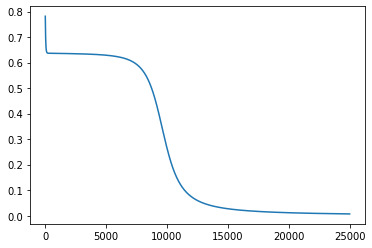

In [75]:
plt.plot(n_epochs, cost_history)